# Load CSV

Given: CSV path, date

Wanted: df

In [1]:
import sys 
sys.path.append("C:/Users/isxzl/OneDrive/Code/AutoGeo")
from sample.dataset import filter_dataframe_by_date

# Assuming you've already read the CSV and selected specific columns
csv_path = r'C:\Datasets\Zhejiang20-23RS\merged_coor.csv'
start_date = '2021-10-01'
end_date = '2021-10-20'

df=filter_dataframe_by_date(csv_path,start_date,end_date)
df

C:\Users\isxzl\anaconda3\envs\EO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Site_number,Site_name,time,Negative_oxygen_ions,longitude,latitude,Air_level
58,58568,三门气象站,2021-10-14 09:00:00,1010.0,121.38,29.11,很清新
60,58568,三门气象站,2021-10-12 13:00:00,1030.0,121.38,29.11,很清新
72,58568,三门气象站,2021-10-03 10:00:00,1000.0,121.38,29.11,很清新
108,58568,三门气象站,2021-10-09 23:00:00,1030.0,121.38,29.11,很清新
149,58568,三门气象站,2021-10-10 18:00:00,1030.0,121.38,29.11,很清新
...,...,...,...,...,...,...,...
1187492,58547,龙游气象站,2021-10-14 21:00:00,1000.0,119.18,29.03,很清新
1187675,58547,龙游气象站,2021-10-04 20:00:00,1880.0,119.18,29.03,很清新
1188032,58547,龙游气象站,2021-10-08 10:00:00,1930.0,119.18,29.03,很清新
1188178,58547,龙游气象站,2021-10-15 23:00:00,4220.0,119.18,29.03,很清新


# Update Data

## Function

In [6]:
import os
import requests
import json
from tqdm import tqdm
import os
import json
import pandas as pd

appsecret = '2fe0465e85584cbb91f55cba55cf1a50'
json_dir = r'C:\Datasets\ZheJiang\json_intermediate'  # Change this to your desired directory
csv_dir = r'C:\Datasets\ZheJiang\csv_intermediate'

def get_total_count(appsecret):
    url = f"https://data.zjzwfw.gov.cn/jdop_front/interfaces/cata_19131/get_total.do?appsecret={appsecret}"
    response = requests.get(url)
    if response.status_code == 200:
        result = response.json()
        if result['status'] == 1:
            return result['data']
        else:
            print("Error:", result['msg'])
    else:
        print("HTTP Error:", response.status_code)
    return 0

def get_data(page_num, page_size, appsecret):
    url = f"http://data.zjzwfw.gov.cn/jdop_front/interfaces/cata_19131/get_data.do?pageNum={page_num}&pageSize={page_size}&appsecret={appsecret}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("HTTP Error:", response.status_code)
        return None

def save_data(data, page_num, json_dir):
    with open(os.path.join(json_dir, f"page_{page_num}.json"), 'w') as f:
        json.dump(data, f)

def update_json():

    page_size = 200

    if not os.path.exists(json_dir):
        os.makedirs(json_dir)

    total_count = get_total_count(appsecret)
    print("Total Count:", total_count)

    total_pages = -(-total_count // page_size)  # Ceiling division
    print("Total Pages:", total_pages)

    last_updated_page = 0
    for i in range(1, total_pages + 1):
        if os.path.exists(os.path.join(json_dir, f"page_{i}.json")):
            last_updated_page = i

    print("Last Updated Page:", last_updated_page)

    for i in range(last_updated_page , total_pages + 1):
        data = get_data(i, page_size, appsecret)
        if data and data['status'] == 1:
            save_data(data, i, json_dir)
            print(f"Page {i} downloaded and saved.")
        elif data:
            print("Error:", data['msg'])
        else:
            print(f"Failed to download page {i}")


import os
import json
import pandas as pd

def process_json_files(json_dir, csv_dir, last_updated_page, batch_process_pages=20):
    # Get the list of json files in the directory
    json_files = sorted([f for f in os.listdir(json_dir) if f.endswith('.json') and f.startswith('page_')],
                        key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Filter out the files that have already been processed
    json_files = [f for f in json_files if int(f.split('_')[1].split('.')[0]) > last_updated_page]

    total_files = len(json_files)
    for start in range(0, total_files, batch_process_pages):
        batch_files = json_files[start:start + batch_process_pages]
        all_data_frames = []

        for json_file in batch_files:
            page_num = int(json_file.split('_')[1].split('.')[0])
            with open(os.path.join(json_dir, json_file), 'r') as f:
                data = json.load(f)
                if data['status'] == 1:
                    df = pd.DataFrame(data['data'])
                    # Rename columns and convert Chinese characters
                    df = df.rename(columns={
                        'ZDMC': 'Site_name',
                        'ZDBH': 'Site_number',
                        'XZQHDM': 'Site_postcode',
                        'XZQMC': 'City_name',
                        'SJ': 'Datetime',
                        'PJDJ': 'Air_level',
                        'FYLZ': 'Negative_oxygen_ions',
                        'PM25_S': 'PM25',
                        'O3_C': 'O3',
                        'WD': 'WD',
                        'SD': 'SD',
                        'QY': 'QY',
                        'FS': 'FS',
                        'FX': 'FX',
                        'JYL': 'JYL',
                        'XH': 'XH',
                    })
                    all_data_frames.append(df)
                    last_updated_page = page_num

        # Concatenate all data frames from this batch
        full_data_frame = pd.concat(all_data_frames, ignore_index=True)

        # Save to CSV
        for site_name, group in full_data_frame.groupby('Site_name'):
            csv_file = os.path.join(csv_dir, f'{site_name}.csv')
            if os.path.exists(csv_file):
                group.to_csv(csv_file, mode='a', header=False, index=False, encoding='utf-8-sig')
            else:
                group.to_csv(csv_file, index=False, encoding='utf-8-sig')

        print(f'Processed and saved data from pages {start + 1} to {start + len(batch_files)}')

    # Update the last updated page number
    with open(os.path.join(csv_dir, 'last.txt'), 'w') as f:
        f.write(str(last_updated_page))

    print('Processing complete.')




## Donwload data

Given:

Wanted: Updated json 

In [ ]:
update_json()

## Update CSV

In [ ]:

batch_process_pages = 20
last_updated_page = 0

if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)

if os.path.exists(os.path.join(csv_dir, 'last.txt')):
    with open(os.path.join(csv_dir, 'last.txt'), 'r') as f:
        last_updated_page = int(f.read().strip())
print("Last Updated Page:", last_updated_page)
# Process JSON files

process_json_files(json_dir, csv_dir, last_updated_page, batch_process_pages)


# Data Cleaning

## Clean Null

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
csv_dir = r'C:\Datasets\ZheJiang\csv_intermediate'
def fill_common_value(df, column_name,fname):
    """
    Fill missing values in the specified column with its most frequent non-null value.
    """
    # Get the value counts for non-null values in the column
    value_counts = df[df[column_name].notnull()][column_name].value_counts()
    
    # If there are no non-null values, we skip filling for this column
    if value_counts.empty:
        print(fname)
        return
    
    # Get the most frequent non-null value
    common_value = value_counts.index[0]
    
    # Fill missing values with the common value
    df[column_name].fillna(common_value, inplace=True)


def update_csv_files(csv_dir):
    """
    Update all CSV files in the specified directory.
    """
    for file_name in tqdm(os.listdir(csv_dir)):
        if file_name.endswith(".csv"):
            file_path = os.path.join(csv_dir, file_name)
            
            # Load CSV into DataFrame
            df = pd.read_csv(file_path)
            
            # Fill missing values for Site_postcode and City_name
            fill_common_value(df, 'Site_postcode',file_name)
            fill_common_value(df, 'City_name',file_name)
            fill_common_value(df, 'Site_number',file_name)
            # Save the updated DataFrame back to the CSV
            df.to_csv(file_path, index=False)




def update_csv_files_null(csv_dir):
    """
    Update all CSV files in the specified directory by replacing '--' with NaN.
    """
    for file_name in tqdm(os.listdir(csv_dir)):
        if file_name.endswith(".csv"):
            file_path = os.path.join(csv_dir, file_name)
            
            # Load CSV into DataFrame
            df = pd.read_csv(file_path)

            # Replace '--' with NaN
            df.replace('--', pd.NA, inplace=True)

            # Save the updated DataFrame back to the CSV
            df.to_csv(file_path, index=False)

update_csv_files_null(csv_dir)
update_csv_files(csv_dir)


## Merge Data

Given: 

directory which includes 
a lot of csv which has first row as column name.

Wanted:
1. merged csv of all fies without coordinate



In [2]:
import pandas as pd
import os
from tqdm import tqdm
# Specify the directory containing the CSV files
directory = r'C:\Datasets\ZheJiang\csv_intermediate'
merged_path = r'C:\Datasets\Zhejiang20-23RS\merged.csv'

# Specify the columns to extract from each CSV
columns_to_extract = ['Site_number', 'Site_name', 'Datetime', 'Negative_oxygen_ions', 'Air_level',"PM25","O3"]

# Initialize an empty DataFrame for merging all files
merged_df = pd.DataFrame()

# Iterate through all files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file
        df = pd.read_csv(file_path, usecols=columns_to_extract)
        
        # Filter rows where "Negative_oxygen_ions" is not null
        df_filtered = df.dropna(subset=['Negative_oxygen_ions'])
        
        # Append the filtered DataFrame to the merged DataFrame
        merged_df = pd.concat([merged_df, df_filtered], ignore_index=True)

# Save the merged DataFrame to a new CSV file

merged_df.to_csv(merged_path, index=False)

print(f'Merged data saved to {merged_path}')


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:30<00:00,  8.71it/s]


Merged data saved to C:\Datasets\Zhejiang20-23RS\merged.csv


## Merge Coordinate
Given:
(site+data) CSV file,

Wanted:
Right Join
 

In [3]:
import pandas as pd

# Paths for the input files and the output file
merged_path = r'C:\Datasets\Zhejiang20-23RS\merged.csv'
site_path = r'C:\Datasets\Zhejiang20-23RS\site.csv'
output_path = r'C:\Datasets\Zhejiang20-23RS\merged_coor.csv'

# Load the dataframes from the CSV files
merged_df = pd.read_csv(merged_path)
site_df = pd.read_csv(site_path)

# Convert the 'Site_number' column in site_df to string
site_df['Site_number'] = site_df['Site_number'].astype(str)

# Perform a left join on the 'Site_number' column
# Assuming 'Site_number' is the common column in both dataframes
merged_with_coor = pd.merge(merged_df, site_df[['Site_number', 'longitude', 'latitude']], 
                            on='Site_number', 
                            how='inner')

merged_with_coor.rename(columns={'Datetime': 'time'}, inplace=True)
merged_with_coor.to_csv(output_path, index=False)

print(f'Merged data with coordinates saved to {output_path}')
merged_with_coor

Merged data with coordinates saved to C:\Datasets\Zhejiang20-23RS\merged_coor.csv


,Site_number,Site_name,time,Air_level,Negative_oxygen_ions,PM25,O3,longitude,latitude
0,58568,三门气象站,2023-03-13 02:00:00,清新,900.0,15.0,59.0,121.38,29.11
1,58568,三门气象站,2023-03-24 02:00:00,清新,920.0,22.0,67.0,121.38,29.11
2,58568,三门气象站,2023-03-13 04:00:00,清新,910.0,18.0,62.0,121.38,29.11
3,58568,三门气象站,2020-02-19 20:00:00,很清新,1040.0,13.0,75.0,121.38,29.11
4,58568,三门气象站,2020-05-21 12:00:00,很清新,1030.0,16.0,101.0,121.38,29.11
...,...,...,...,...,...,...,...,...,...
1188536,58547,龙游气象站,2022-03-25 10:00:00,很清新,1550.0,15.0,53.0,119.18,29.03
1188537,58547,龙游气象站,2022-03-25 11:00:00,清新,850.0,19.0,34.0,119.18,29.03
1188538,58547,龙游气象站,2023-01-09 09:00:00,清新,1140.0,53.0,25.0,119.18,29.03
1188539,58547,龙游气象站,2022-12-25 14:00:00,清新,1140.0,33.0,72.0,119.18,29.03


# EDA

## Check file state
Given: directory, with a lot of csv which has first row as column name.

Wanted:
1. get list of csv without data.
2. get list of csv has column of "Site_number" with all data is null.
3. get list of csv has column of "Site_postcode" with all data is null.
4. get list of csv with the null percentage of column "Negative_oxygen_ions" which lower than 5%.





In [14]:
import pandas as pd
import os
from tqdm import tqdm
# Specify the directory containing the CSV files
directory = r'C:\Datasets\ZheJiang\csv_intermediate'

# Initialize lists to keep track of CSV files meeting the criteria
csv_without_data_or_only_headers = []
csv_site_number_null = []
csv_site_postcode_null = []
csv_negative_oxygen_ions_low_null_percentage = []

# Walk through the files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file
        try:
            df = pd.read_csv(file_path)
            
            # Check if the CSV file is empty or only contains headers
            if df.empty or df.shape[0] == 0:
                csv_without_data_or_only_headers.append(filename)
                continue  # Move to the next file since this one has no data
            
            # Check if "Site_number" column exists and all its data is null
            if  df["Site_number"].isnull().all():
                csv_site_number_null.append(filename)
            
            # Check if "Site_postcode" column exists and all its data is null
            if  df["Site_postcode"].isnull().all():
                csv_site_postcode_null.append(filename)
            
            # Check for "Negative_oxygen_ions" null percentage lower than 5%
            
            null_percentage = (df["Negative_oxygen_ions"].isnull().sum() / len(df)) * 100
            if null_percentage > 95:
                csv_negative_oxygen_ions_low_null_percentage.append(filename)
        
        except pd.errors.EmptyDataError:
            # File is empty or malformed; consider it as without data or only headers
            csv_without_data_or_only_headers.append(filename)

# Print out the results
print("CSV without data or only headers:", csv_without_data_or_only_headers)
print("CSV with 'Site_number' all null:", csv_site_number_null)
print("CSV with 'Site_postcode' all null:", csv_site_postcode_null)
print("'Negative_oxygen_ions' null percentage lower than 5%:", csv_negative_oxygen_ions_low_null_percentage)


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:13<00:00, 19.89it/s]

CSV without data or only headers: []
CSV with 'Site_number' all null: []
CSV with 'Site_postcode' all null: ['兰亭国家森林公园.csv', '嘉善西塘.csv', '奉化溪口雪窦山.csv', '嵊州温泉城.csv', '平阳满田森林公园.csv', '庆元巾子峰.csv', '庆元百山祖.csv', '庆元马蹄岙坝头.csv', '德清下渚湖.csv', '文成大峃环保站.csv', '景宁气象站.csv', '望江苑.csv', '横腊村.csv', '永嘉书院森林康养基地.csv', '洞头沿海森林康养基地.csv', '浦江仙华山.csv', '瑞安奇云林场.csv', '磐安百丈潭.csv', '磐安花溪.csv', '诸暨五泄.csv', '金华气象站.csv', '雁荡山森林公园.csv', '鼓山公园气象站.csv', '龙泉凤阳山.csv', '龙湾瑶溪风景名胜区.csv']
'Negative_oxygen_ions' null percentage lower than 5%: ['兰亭国家森林公园.csv', '奉化溪口雪窦山.csv', '庆元巾子峰.csv', '庆元百山祖.csv', '瓯海茶山.csv', '雁荡山森林公园.csv']


147

## Null Statistics

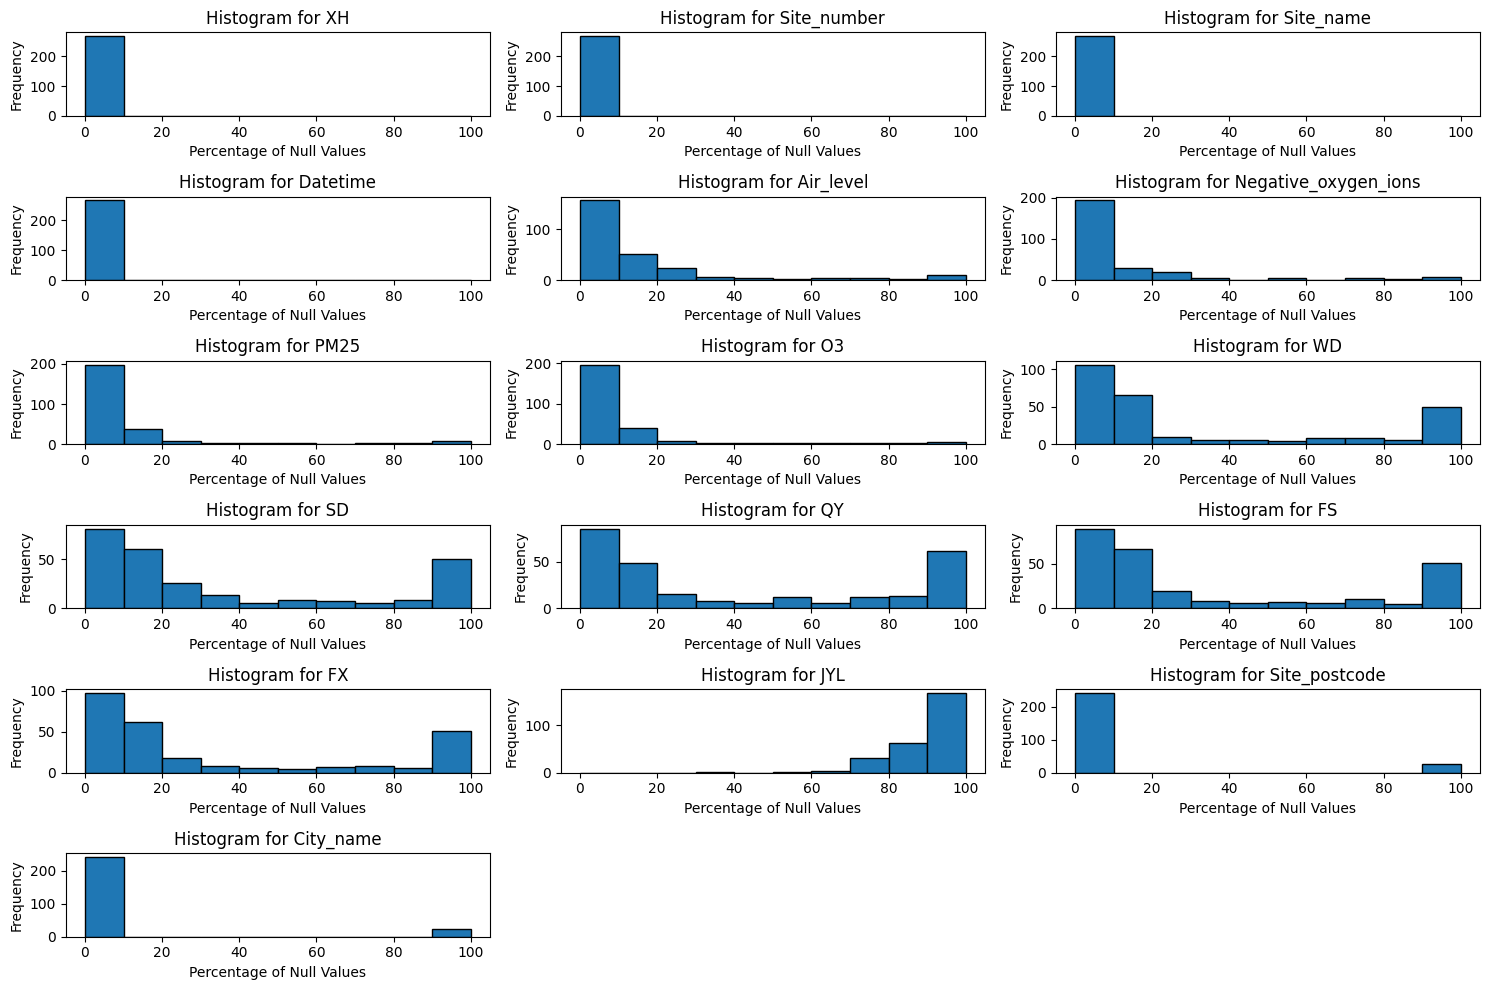

In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def calculate_null_percentage(df):
    """
    Calculate percentage of null values and "--" for each column in a DataFrame.
    """
    null_percent = (df.isnull() | (df == "--")).sum() / len(df) * 100
    return null_percent

def generate_histograms(data_dict):
    """
    Generate histograms for the provided data dictionary.
    """
    fig, axes = plt.subplots(nrows=len(data_dict) // 3 + (len(data_dict) % 3 != 0), ncols=3, figsize=(15, 10))
    for ax, (col, data) in zip(axes.ravel(), data_dict.items()):
        ax.hist(data, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], edgecolor='black')
        ax.set_title(f'Histogram for {col}')
        ax.set_xlabel('Percentage of Null Values')
        ax.set_ylabel('Frequency')

    # Remove any unused subplots
    for idx in range(len(data_dict), len(axes.ravel())):
        fig.delaxes(axes.ravel()[idx])
        
    plt.tight_layout()
    plt.show()


all_data = {col: [] for col in ['XH', 'Site_number', 'Site_name', 'Datetime', 'Air_level', 'Negative_oxygen_ions', 
                                'PM25', 'O3', 'WD', 'SD', 'QY', 'FS', 'FX', 'JYL', 'Site_postcode', 'City_name']}

# Iterate over each CSV file in the directory
for file_name in os.listdir(csv_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(csv_dir, file_name)
        
        # Load CSV into DataFrame
        df = pd.read_csv(file_path)
        
        # Calculate percentage of null values for each column
        null_percent = calculate_null_percentage(df)
        
        # Collect data for histograms
        for col in null_percent.index:
            all_data[col].append(null_percent[col])

# Plot histograms for each column
generate_histograms(all_data)



## Check Datetime

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
def generate_date_range():
    """
    Generate date range from 2020/01/01 0:00:00 to today.
    """
    start_date = pd.Timestamp('2020-01-01 00:00:00')
    end_date = pd.Timestamp(datetime.datetime.now())
    return pd.date_range(start_date, end_date, freq='H')

def check_dates_in_csv(file_path, all_dates):
    """
    Check existence of each date in the given CSV file.
    Return a boolean array where True indicates the date exists and False otherwise.
    """
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert column to datetime format
    return all_dates.isin(df['Datetime'])

def plot_date_gaps(csv_dir):
    """
    Plot horizontal bars for each CSV file showing date gaps, one by one.
    """
    all_dates = generate_date_range()
    csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

    for csv_file in tqdm(csv_files):
        fig, ax = plt.subplots(figsize=(10, 1))  # Single subplot for each file
        
        file_path = os.path.join(csv_dir, csv_file)
        date_exists = check_dates_in_csv(file_path, all_dates)
        
        ax.barh(csv_file, len(all_dates), color='white')  # Background bar
        missing_dates = [idx for idx, exists in enumerate(date_exists) if not exists]
        for missing in missing_dates:
            ax.barh(csv_file, 1, left=missing, color='black')  # Missing date blocks
        
        ax.set_xlim(0, len(all_dates))
        ax.set_yticks([])  # Remove y-axis labels
        plt.tight_layout()
        plt.show()
csv_dir = r'C:\Datasets\ZheJiang\csv_intermediate'
plot_date_gaps(csv_dir)


  0%|                                                                                          | 0/267 [00:00<?, ?it/s]

In [ ]:
ZCuoZ2eO0MkPr9GbCttcRlGs68dyNwDG

# Get Site Coordinate

In [10]:
import pandas as pd
import os

# Assuming dir_path is the directory containing the CSV files
dir_path = 'C:\Datasets\ZheJiang\csv_intermediate'  # Update this to your directory path
output_csv_path = r'C:\Datasets\Zhejiang20-23RS/site_complete.csv'  # Update this to your desired output path


# List all CSV files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# Initialize an empty DataFrame to store site info
site_info_list = []  # Use a list to store each DataFrame
from tqdm import tqdm
for file in tqdm(csv_files):
    file_path = os.path.join(dir_path, file)
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Assuming the values are same for each row, we take the first non-null row for required columns
    try:
        site_info = df[['Site_number', 'Site_name', 'Site_postcode', 'City_name']].dropna().iloc[0]
    except:
        site_info = df[['Site_number', 'Site_name', 'Site_postcode', 'City_name']].iloc[0]
    
    # Append this row to our list
    site_info_list.append(site_info)

# Concatenate all DataFrames in the list into a single DataFrame
site_info_df = pd.concat(site_info_list, axis=1).transpose()

# Save the resulting DataFrame to the specified output path
site_info_df.to_csv(output_csv_path, index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [00:13<00:00, 19.45it/s]
